In [49]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
%matplotlib inline
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [50]:
m = 5           # 5, 50, 100, 500, 2000

In [51]:
train_size = 500          # 100, 500, 2000, 10000

# Generate dataset

In [52]:
np.random.seed(12)
y = np.random.randint(0,10,5000)
idx= []
for i in range(10):
    print(i,sum(y==i))
    idx.append(y==i)

0 530
1 463
2 494
3 517
4 488
5 497
6 493
7 507
8 492
9 519


In [53]:
x = np.zeros((5000,2))

In [54]:
np.random.seed(12)
x[idx[0],:] = np.random.multivariate_normal(mean = [5,5],cov=[[0.1,0],[0,0.1]],size=sum(idx[0]))
x[idx[1],:] = np.random.multivariate_normal(mean = [6,6],cov=[[0.1,0],[0,0.1]],size=sum(idx[1]))
x[idx[2],:] = np.random.multivariate_normal(mean = [5.5,6.5],cov=[[0.1,0],[0,0.1]],size=sum(idx[2]))
x[idx[3],:] = np.random.multivariate_normal(mean = [-1,0],cov=[[0.1,0],[0,0.1]],size=sum(idx[3]))
x[idx[4],:] = np.random.multivariate_normal(mean = [0,2],cov=[[0.1,0],[0,0.1]],size=sum(idx[4]))
x[idx[5],:] = np.random.multivariate_normal(mean = [1,0],cov=[[0.1,0],[0,0.1]],size=sum(idx[5]))
x[idx[6],:] = np.random.multivariate_normal(mean = [0,-1],cov=[[0.1,0],[0,0.1]],size=sum(idx[6]))
x[idx[7],:] = np.random.multivariate_normal(mean = [0,0],cov=[[0.1,0],[0,0.1]],size=sum(idx[7]))
x[idx[8],:] = np.random.multivariate_normal(mean = [-0.5,-0.5],cov=[[0.1,0],[0,0.1]],size=sum(idx[8]))
x[idx[9],:] = np.random.multivariate_normal(mean = [0.4,0.2],cov=[[0.1,0],[0,0.1]],size=sum(idx[9]))

In [55]:
x[idx[0]][0], x[idx[5]][5] 

(array([5.14957125, 4.78451422]), array([0.87756167, 0.00457805]))

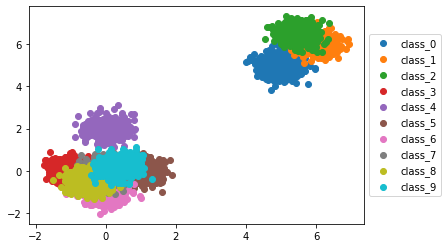

In [56]:
for i in range(10):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [57]:
bg_idx = [ np.where(idx[3] == True)[0], 
          np.where(idx[4] == True)[0], 
          np.where(idx[5] == True)[0],
          np.where(idx[6] == True)[0], 
          np.where(idx[7] == True)[0], 
          np.where(idx[8] == True)[0],
          np.where(idx[9] == True)[0]]

bg_idx = np.concatenate(bg_idx, axis = 0)
bg_idx.shape

(3513,)

In [58]:
np.unique(bg_idx).shape

(3513,)

In [59]:
x = x - np.mean(x[bg_idx], axis = 0, keepdims = True)


In [60]:
np.mean(x[bg_idx], axis = 0, keepdims = True), np.mean(x, axis = 0, keepdims = True)

(array([[-1.04275003e-16,  6.74571889e-17]]),
 array([[1.63261967, 1.69552644]]))

In [61]:
x = x/np.std(x[bg_idx], axis = 0, keepdims = True)

In [62]:
np.std(x[bg_idx], axis = 0, keepdims = True), np.std(x, axis = 0, keepdims = True)

(array([[1., 1.]]), array([[3.93071885, 3.03840862]]))

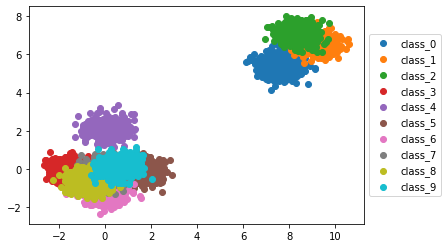

In [63]:
for i in range(10):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [64]:
foreground_classes = {'class_0','class_1', 'class_2'}

background_classes = {'class_3','class_4', 'class_5', 'class_6','class_7', 'class_8', 'class_9'}

In [65]:
fg_class  = np.random.randint(0,3)
fg_idx = np.random.randint(0,m)
train_data=[]
a = []
fg_instance = np.array([[0.0,0.0]])
bg_instance = np.array([[0.0,0.0]])

for i in range(m):
  if i == fg_idx:
    b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
    fg_instance += x[b]
    a.append(x[b])
    print("foreground "+str(fg_class)+" present at " + str(fg_idx))
  else:
    bg_class = np.random.randint(3,10)
    b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
    bg_instance += x[b]
    a.append(x[b])
    print("background "+str(bg_class)+" present at " + str(i))

a = np.concatenate(a,axis=0)
print(a.shape)

print(fg_class , fg_idx)

background 5 present at 0
background 6 present at 1
foreground 2 present at 2
background 5 present at 3
background 3 present at 4
(5, 2)
2 2


In [66]:
a

array([[ 1.52560273, -0.1298488 ],
       [-0.4226508 , -1.2003313 ],
       [ 8.5153438 ,  7.02349438],
       [ 2.09728368, -0.24465132],
       [-0.98608769, -0.75123246]])

In [67]:
fg_instance

array([[8.5153438 , 7.02349438]])

In [68]:
bg_instance

array([[ 2.21414792, -2.32606388]])

In [69]:
(fg_instance+bg_instance)/m , m

(array([[2.14589834, 0.9394861 ]]), 5)

In [70]:
np.reshape(a,(2*m,1))

array([[ 1.52560273],
       [-0.1298488 ],
       [-0.4226508 ],
       [-1.2003313 ],
       [ 8.5153438 ],
       [ 7.02349438],
       [ 2.09728368],
       [-0.24465132],
       [-0.98608769],
       [-0.75123246]])

In [71]:
# mosaic_list_of_images =[]
# mosaic_label = []
train_label=[]
fore_idx=[]
train_data = []
for j in range(train_size):
  np.random.seed(j)
  fg_instance = torch.zeros([2], dtype=torch.float64) #np.array([[0.0,0.0]])
  bg_instance = torch.zeros([2], dtype=torch.float64) #np.array([[0.0,0.0]])
  # a=[]

  for i in range(m):
    if i == fg_idx:
      fg_class  = np.random.randint(0,3)
      b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
      fg_instance += x[b]
      # a.append(x[b])
      # print("foreground "+str(fg_class)+" present at " + str(fg_idx))
    else:
      bg_class = np.random.randint(3,10)
      b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
      bg_instance += x[b]
      # a.append(x[b])
      # print("background "+str(bg_class)+" present at " + str(i))
  train_data.append((fg_instance+bg_instance)/m)
  # a = np.concatenate(a,axis=0)
  # mosaic_list_of_images.append(np.reshape(a,(2*m,1)))
  train_label.append(fg_class)
  fore_idx.append(fg_idx)

In [72]:
 train_data[0], train_label[0]

(tensor([[1.9415, 1.1735]], dtype=torch.float64), 1)

In [73]:
train_data = torch.stack(train_data, axis=0)
train_data.shape, len(train_label)

(torch.Size([500, 1, 2]), 500)

In [74]:
test_label=[]
# fore_idx=[]
test_data = []
for j in range(1000):
  np.random.seed(j)
  fg_instance = torch.zeros([2], dtype=torch.float64) #np.array([[0.0,0.0]])

  fg_class  = np.random.randint(0,3)
  b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
  fg_instance += x[b]
  # a.append(x[b])
  # print("foreground "+str(fg_class)+" present at " + str(fg_idx))

  test_data.append((fg_instance)/m)
  # a = np.concatenate(a,axis=0)
  # mosaic_list_of_images.append(np.reshape(a,(2*m,1)))
  test_label.append(fg_class)
  # fore_idx.append(fg_idx)

In [75]:
test_data[0], test_label[0]

(tensor([[1.6196, 1.0052]], dtype=torch.float64), 0)

In [76]:
test_data = torch.stack(test_data, axis=0)
test_data.shape, len(test_label)

(torch.Size([1000, 1, 2]), 1000)

In [77]:
x1 = (train_data).numpy()
y1 = np.array(train_label)

In [78]:
x1[y1==0,0]

array([[2.31083719, 1.29582207],
       [2.55617415, 0.82339394],
       [2.05459714, 1.28499008],
       [1.70525849, 1.77512975],
       [1.54031539, 0.53982597],
       [1.37520709, 1.11561758],
       [1.44761575, 1.18088703],
       [1.53792062, 1.14562282],
       [1.82083894, 1.02595941],
       [1.36488786, 1.17364008],
       [1.14608175, 0.68747298],
       [1.88163464, 1.18488168],
       [1.51963717, 1.46941846],
       [1.51771884, 2.11783694],
       [1.36489497, 1.87599498],
       [1.90814419, 1.14836183],
       [1.69137383, 0.5168221 ],
       [1.25445685, 0.7725669 ],
       [0.94311049, 0.90360228],
       [1.44034429, 2.24659856],
       [1.6786334 , 1.5440739 ],
       [1.2438062 , 1.80364468],
       [1.21075277, 1.61354854],
       [1.85554257, 0.79036512],
       [1.46278414, 0.90666355],
       [1.72961448, 0.87452299],
       [1.75948675, 0.88091133],
       [1.81877001, 1.28780841],
       [1.15716597, 1.17923006],
       [1.42352501, 0.36204016],
       [1.

In [79]:
x1[y1==0,0][:,0]

array([2.31083719, 2.55617415, 2.05459714, 1.70525849, 1.54031539,
       1.37520709, 1.44761575, 1.53792062, 1.82083894, 1.36488786,
       1.14608175, 1.88163464, 1.51963717, 1.51771884, 1.36489497,
       1.90814419, 1.69137383, 1.25445685, 0.94311049, 1.44034429,
       1.6786334 , 1.2438062 , 1.21075277, 1.85554257, 1.46278414,
       1.72961448, 1.75948675, 1.81877001, 1.15716597, 1.42352501,
       1.57715537, 1.5293098 , 1.66313291, 1.56648775, 2.38567877,
       1.70771039, 1.04282909, 1.83563808, 1.83695179, 1.56194808,
       1.27509123, 1.22885388, 2.24437237, 2.17451706, 0.69990137,
       1.94797391, 2.62403838, 1.84525267, 2.10841107, 1.70767505,
       1.57948011, 1.33215722, 1.77871085, 1.12023719, 1.59911174,
       1.17328073, 1.63065423, 1.04120479, 1.55422321, 1.52339184,
       1.18964882, 0.66131841, 1.70022455, 0.87296164, 2.11258235,
       2.36313962, 1.05094033, 1.51800435, 1.3419238 , 1.46297891,
       1.49407907, 1.39658293, 1.59323094, 2.31660864, 1.72260

In [80]:
x1[y1==0,0][:,1]

array([1.29582207, 0.82339394, 1.28499008, 1.77512975, 0.53982597,
       1.11561758, 1.18088703, 1.14562282, 1.02595941, 1.17364008,
       0.68747298, 1.18488168, 1.46941846, 2.11783694, 1.87599498,
       1.14836183, 0.5168221 , 0.7725669 , 0.90360228, 2.24659856,
       1.5440739 , 1.80364468, 1.61354854, 0.79036512, 0.90666355,
       0.87452299, 0.88091133, 1.28780841, 1.17923006, 0.36204016,
       1.28219434, 0.73782214, 1.63731343, 1.22911101, 0.5837939 ,
       0.88217516, 1.23611846, 1.36342367, 1.21282566, 0.84934563,
       0.97661684, 0.7470571 , 1.07163737, 1.82223524, 1.2225546 ,
       0.95274703, 1.20573736, 1.54738559, 1.82358666, 1.19073174,
       1.25128021, 0.72727653, 1.17517011, 2.07966776, 0.84911766,
       1.23816774, 1.55067469, 1.07023594, 1.51357034, 0.97922212,
       1.79517579, 1.36965356, 1.14260043, 1.55138739, 0.70516807,
       1.16333272, 1.08271819, 1.6262457 , 1.33810884, 1.87450759,
       1.12725478, 1.07570589, 0.69407916, 1.35037307, 1.78366

Text(0.5, 1.0, 'dataset4 CIN with alpha = 1/5')

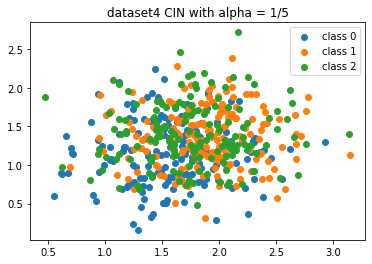

In [81]:
x1 = (train_data).numpy()
y1 = np.array(train_label)

plt.scatter(x1[y1==0,0][:,0], x1[y1==0,0][:,1], label='class 0')
plt.scatter(x1[y1==1,0][:,0], x1[y1==1,0][:,1], label='class 1')
plt.scatter(x1[y1==2,0][:,0], x1[y1==2,0][:,1], label='class 2')
plt.legend()
plt.title("dataset4 CIN with alpha = 1/"+str(m))

Text(0.5, 1.0, 'test dataset4')

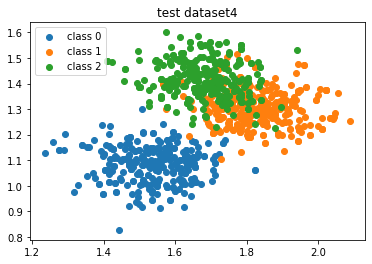

In [82]:
x1 = (test_data).numpy()
y1 = np.array(test_label)

plt.scatter(x1[y1==0,0][:,0], x1[y1==0,0][:,1], label='class 0')
plt.scatter(x1[y1==1,0][:,0], x1[y1==1,0][:,1], label='class 1')
plt.scatter(x1[y1==2,0][:,0], x1[y1==2,0][:,1], label='class 2')
plt.legend()
plt.title("test dataset4")

In [83]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    #self.fore_idx = fore_idx
    
  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx] #, self.fore_idx[idx]



In [84]:
train_data[0].shape, train_data[0]

(torch.Size([1, 2]), tensor([[1.9415, 1.1735]], dtype=torch.float64))

In [85]:
batch = 200

traindata_1 = MosaicDataset(train_data, train_label )
trainloader_1 = DataLoader( traindata_1 , batch_size= batch ,shuffle=True)


In [86]:
testdata_1 = MosaicDataset(test_data, test_label )
testloader_1 = DataLoader( testdata_1 , batch_size= batch ,shuffle=False)


In [87]:
# testdata_11 = MosaicDataset(test_dataset, labels )
# testloader_11 = DataLoader( testdata_11 , batch_size= batch ,shuffle=False)

In [88]:
class Whatnet(nn.Module):
    def __init__(self):
        super(Whatnet,self).__init__()
        self.linear1 = nn.Linear(2,50)
        self.linear2 = nn.Linear(50,3)

        torch.nn.init.xavier_normal_(self.linear1.weight)
        torch.nn.init.zeros_(self.linear1.bias)
        torch.nn.init.xavier_normal_(self.linear2.weight)
        torch.nn.init.zeros_(self.linear2.bias)

    def forward(self,x):
        x = F.relu(self.linear1(x))
        x = (self.linear2(x))

        return x[:,0]

In [89]:
def calculate_loss(dataloader,model,criter):
  model.eval()
  r_loss = 0
  with torch.no_grad():
    for i, data in enumerate(dataloader, 0):
      inputs, labels = data
      inputs, labels = inputs.to("cuda"),labels.to("cuda")
      outputs = model(inputs)
      # print(outputs.shape)
      loss = criter(outputs, labels)
      r_loss += loss.item()
  return r_loss/(i+1)

In [90]:
def test_all(number, testloader,net):
    correct = 0
    total = 0
    out = []
    pred = []
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to("cuda"),labels.to("cuda")
            out.append(labels.cpu().numpy())
            outputs= net(images)
            _, predicted = torch.max(outputs.data, 1)
            pred.append(predicted.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    pred = np.concatenate(pred, axis = 0)
    out = np.concatenate(out, axis = 0)
    print("unique out: ",  np.unique(out), "unique pred: ", np.unique(pred) )
    print("correct: ", correct, "total ",  total)
    print('Accuracy of the network on the %d test dataset %d: %.2f %%' % (total, number , 100 * correct / total))

In [97]:
def train_all(trainloader, ds_number, testloader_list, lr_list):
  
  final_loss = []
  for LR in lr_list:    
    print("--"*20, "Learning Rate used is", LR)
    
    torch.manual_seed(14)
    net = Whatnet().double()
    net = net.to("cuda")
    
    criterion_net = nn.CrossEntropyLoss()
    optimizer_net = optim.Adam(net.parameters(), lr=LR ) #, momentum=0.9)
    
    acti = []
    loss_curi = []
    epochs = 1000
    running_loss = calculate_loss(trainloader,net,criterion_net)
    loss_curi.append(running_loss)
    print('epoch: [%d ] loss: %.3f' %(0,running_loss)) 
    for epoch in range(epochs): # loop over the dataset multiple times
        ep_lossi = []

        running_loss = 0.0
        net.train()
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to("cuda"),labels.to("cuda")

            # zero the parameter gradients
            optimizer_net.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            # print(outputs.shape)
            loss = criterion_net(outputs, labels)
            # print statistics
            running_loss += loss.item()
            loss.backward()
            optimizer_net.step()

        running_loss = calculate_loss(trainloader,net,criterion_net)
        if(epoch%200 == 0):
          print('epoch: [%d] loss: %.3f' %(epoch + 1,running_loss)) 
        loss_curi.append(running_loss)   #loss per epoch
        if running_loss<=0.05:
          print('epoch: [%d] loss: %.3f' %(epoch + 1,running_loss))
          break

    print('Finished Training')
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels = data
            images, labels = images.to("cuda"), labels.to("cuda")
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the %d train images: %.2f %%' % (total,  100 * correct / total))
    
    for i, j in enumerate(testloader_list):
        test_all(i+1, j,net)
    
    print("--"*40)
    
    final_loss.append(loss_curi) 
  return final_loss
    

In [98]:
train_loss_all=[]

testloader_list= [ testloader_1]
lr_list = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5 ]

In [99]:
fin_loss = train_all(trainloader_1, 1, testloader_list, lr_list)
train_loss_all.append(fin_loss)

---------------------------------------- Learning Rate used is 0.0001
epoch: [0 ] loss: 1.149
epoch: [1] loss: 1.152
epoch: [201] loss: 1.092
epoch: [401] loss: 1.077
epoch: [601] loss: 1.071
epoch: [801] loss: 1.063
Finished Training
Accuracy of the network on the 500 train images: 49.00 %
unique out:  [0 1 2] unique pred:  [0 1 2]
correct:  560 total  1000
Accuracy of the network on the 1000 test dataset 1: 56.00 %
--------------------------------------------------------------------------------
---------------------------------------- Learning Rate used is 0.0005
epoch: [0 ] loss: 1.149
epoch: [1] loss: 1.145
epoch: [201] loss: 1.056
epoch: [401] loss: 1.032
epoch: [601] loss: 1.023
epoch: [801] loss: 1.026
Finished Training
Accuracy of the network on the 500 train images: 48.80 %
unique out:  [0 1 2] unique pred:  [0 1 2]
correct:  689 total  1000
Accuracy of the network on the 1000 test dataset 1: 68.90 %
-----------------------------------------------------------------------------

In [100]:
%matplotlib inline

In [101]:
len(fin_loss)

8

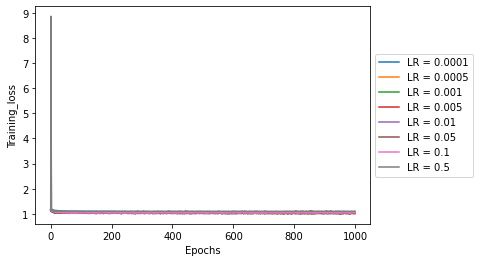

In [102]:
for i,j in enumerate(fin_loss):
    plt.plot(j,label ="LR = "+str(lr_list[i]))
    

plt.xlabel("Epochs")
plt.ylabel("Training_loss")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))